<a href="https://colab.research.google.com/github/fudw/dice-detection-for-board-games/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dice Detection for Board Games

### *by Dawei Fu (August 2021)*

<br/><br/>

In this project, I develop a object detection model based on yolov5 for detection of dice for board games together with a colleague. 
<br/><br/>
I first pre-train the model on a public dataset of dice with bounding boxes and labels. Then we collect a small set of images (~100) under conditions close to the real "production" environment. I manually label this small dataset with bounding boxes, and use it to fine-tune the model.

## I. Download yolov5 model and public data for pretraining

In [1]:
from google.colab import output

# clone yolov5 repo
!git clone https://github.com/ultralytics/yolov5 
!pip install -r yolov5/requirements.txt

# clone my own repo
!git clone https://github.com/fudw/dice-detection-for-board-games.git

# download dataset from https://public.roboflow.com/object-detection/dice/
!wget https://public.roboflow.com/ds/VdKh306UT4?key=4OgEXgYGDp
!unzip VdKh306UT4?key=4OgEXgYGDp
output.clear()
!echo "Data downloaded!"

Data downloaded!


In [2]:
!pip install wandb -qqq
!pip uninstall -y opencv-python-headless
!pip install opencv-python-headless==4.1.2.30
!pip install --upgrade albumentations
output.clear()

# import ALL the things
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from matplotlib import pyplot as plt
import yaml
from shutil import copyfile
import wandb
from PIL import Image
import time

# set up Weights & Biases for tracking and visualisation
wandb.login()

seed = 9
random.seed(seed)

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Setup complete. Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [3]:
# check for downloaded files
os.listdir()

['.config',
 'dice-detection-for-board-games',
 'yolov5',
 'data.yaml',
 'README.dataset.txt',
 'VdKh306UT4?key=4OgEXgYGDp',
 'README.roboflow.txt',
 'export',
 'sample_data']

## II. Exploratory data analysis

In [4]:
os.rename('export', 'dice_dataset')

In [5]:
# find paths to images and labels

root = os.path.abspath('dice_dataset')
image_dir = os.path.join(root, 'images')
label_dir = os.path.join(root, 'labels')

In [6]:
# create lists for file names
image_names = list(sorted(os.listdir(image_dir)))
label_names = list(sorted(os.listdir(label_dir)))

In [7]:
# check total number of examples
print(f'There are {len(image_names)} examples in total')

There are 718 examples in total


In [8]:
# read yaml file for class names conversion
with open("data.yaml", 'r') as file:
  yaml_file = yaml.safe_load(file)
print(yaml_file)
class_labels = yaml_file['names']
print(class_labels)

{'train': '../train/images', 'val': '../valid/images', 'nc': 6, 'names': ['1', '2', '3', '4', '5', '6']}
['1', '2', '3', '4', '5', '6']


In [9]:
# get chunk of first file's name
print(image_names[0].split(".")[0])

0BrzNN9qMnzQlQPZ1sso


In [10]:
# check label corresponding to this image
label_file = os.path.join(label_dir, label_names[0])
with open(label_file, 'r') as file:
  targets = file.read()
targets = targets.split('\n')
targets

['1 0.4174933862433862 0.3835565476190476 0.08167989417989419 0.043402777777777776']

In [11]:
# set up columns for dataframe
col = ['image_id', 'class', 'centre_x', 'centre_y', 'width', 'height']
image_df = pd.DataFrame(columns = col)
image_df

,image_id,class,centre_x,centre_y,width,height


In [12]:
# load label into dictionary format
row = {}
row[col[0]] = label_names[0][:-4]
for i, t in enumerate(targets[0].split(' ')):
  row[col[i+1]] = float(t)
row

{'centre_x': 0.4174933862433862,
 'centre_y': 0.3835565476190476,
 'class': 1.0,
 'height': 0.043402777777777776,
 'image_id': '0BrzNN9qMnzQlQPZ1sso',
 'width': 0.08167989417989419}

In [13]:
# create entry in dataframe with file name and label data
image_df.append(row, ignore_index = True)

,image_id,class,centre_x,centre_y,width,height
0,0BrzNN9qMnzQlQPZ1sso,1.0,0.417493,0.383557,0.08168,0.043403


In [14]:
# set up helper functions to go through entire dataset
def get_targets(label_dir, label_name):
  
  label_file = os.path.join(label_dir, label_name)
  with open(label_file, 'r') as file:
    targets = file.read()
  
  return targets.split('\n')

def get_row(label_dir, label_name, targets, col):
  
  row = {}
  row[col[0]] = label_name[:-4]
  for i, t in enumerate(targets.split(' ')):
    row[col[i+1]] = float(t)
  
  return row

def add_targets_to_df(df, label_dir, label_name):
  
  targets = get_targets(label_dir, label_name)
  for target in targets:
    row = get_row(label_dir, label_name, target, df.columns)
    df = df.append(row, ignore_index = True)
  
  return df

def create_image_df_with_labels(col, label_dir, label_names):
  
  df = pd.DataFrame(columns = col)
  for name in label_names:
    df = add_targets_to_df(df, label_dir, name)
  
  return df


In [15]:
# create final dataframe
raw_df = create_image_df_with_labels(col, label_dir, label_names)
raw_df['class'] = raw_df['class'].astype('int')
raw_df

,image_id,class,centre_x,centre_y,width,height
0,0BrzNN9qMnzQlQPZ1sso,1,0.417493,0.383557,0.081680,0.043403
1,0kpaB4UeoohBVODkOmGd,3,0.389385,0.640625,0.034061,0.023313
2,0kpaB4UeoohBVODkOmGd,5,0.675430,0.340278,0.024802,0.014385
3,0thII0LnXrzeDTZ6HbiS,3,0.528935,0.426711,0.081680,0.045387
4,1W3kCdCcSnq0jkQiZZ00,5,0.537822,0.501157,0.019593,0.029431
...,...,...,...,...,...,...
1929,zcDdJ83uFyJdnSy8ITcG,0,0.473380,0.667287,0.031415,0.020089
1930,zdYhuzHS1d5dtxnIkb5H,2,0.630622,0.483507,0.039683,0.031002
1931,zdYhuzHS1d5dtxnIkb5H,0,0.596726,0.384797,0.042659,0.031994
1932,zoYU94l6w95JmizBxoS7,1,0.661376,0.549355,0.042328,0.032242


In [16]:
class_counts = raw_df['class'].value_counts()
class_counts

5    426
2    390
3    364
0    290
1    274
4    190
Name: class, dtype: int64

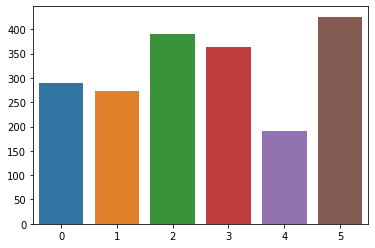

In [17]:
sns.barplot(x=class_counts.index, y=class_counts.values)

## III. Experiment with data augmentation

In [18]:
def get_label_and_boxes(image_id, df):

  rows = df[df.image_id == image_id.split(".")[0]]

  return rows['class'].values, rows[box_cols].values

In [19]:
box_cols = col[-4:]
box_cols

['centre_x', 'centre_y', 'width', 'height']

In [20]:
class dice_pretrain_dataset(torch.utils.data.Dataset):

  def __init__(self, root, image_ids, df, transforms = None):

    super().__init__()
    self.root = root
    self.image_ids = image_ids
    self.df = df
    self.transforms = transforms

  def __len__(self):

    return len(self.image_ids)

  def __getitem__(self, idx):

    image_id = self.image_ids[idx]
    image_path = os.path.join(image_dir, image_id)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    target = {}
    labels, boxes = get_label_and_boxes(image_id, self.df)
    areas = boxes[:,2] * boxes[:, 3]
    iscrowd = torch.zeros((len(labels),))
    #image_id = torch.tensor([image_id])
    labels = torch.as_tensor(labels, dtype = torch.float32)
    boxes = torch.as_tensor(boxes, dtype = torch.float32)
    areas = torch.as_tensor(areas, dtype = torch.float32)
    target['boxes'] = boxes
    target['labels'] = labels
    target['areas'] = areas
    target['iscrowd'] = iscrowd
    target['image_id'] = image_id

    if self.transforms is not None:
      transformed = self.transforms(image = img, bboxes = target['boxes'], class_labels = target['labels'])
      img = transformed['image']
      target['boxes'] = transformed['bboxes']
      target['labels'] = transformed['class_labels']
      
    return img, target
    

### Visualise bounding boxes

In [ ]:
#@title ####(not used) old draw function
def draw_bbox(box, img_width, img_height, color = 'green'):

  rectangle = plt.Rectangle((img_width*box[0]-0.5*img_width*box[2], img_height*box[1]-0.5*img_height*box[3]), 
                            img_width*box[2], img_height*box[3], color = color, fill = False, lw = 3)
  return rectangle

def show_bboxes(img, bb):
  plt.figure(figsize = (14, 20))
  plt.imshow(img)
  boxes = np.array(bb, dtype = np.float32)
  print(boxes.shape)
  for box in list(boxes):
    plt.gca().add_patch(draw_bbox(box, img.width, img.height))

In [21]:
# draw a single bounding box with label on the image
def visualise_bbox(img, bbox, class_name, colour=(0, 205, 0), thickness=2):

  img = np.transpose(img.numpy(), (1, 2, 0))
  img_w, img_h = img.shape[1], img.shape[0]
  x_centre, y_centre, w, h = bbox
  x_min, x_max, y_min, y_max = int(img_w * (x_centre - 0.5 * w)), int(img_w * (x_centre + 0.5 * w)), int(img_h * (y_centre - 0.5 * h)), int(img_h * (y_centre + 0.5 * h))
  cv2.rectangle(img, (x_min, y_min), (x_max, y_max), colour, thickness)
  ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 1)    
  cv2.rectangle(img, (x_min, y_min - int(1.5 * text_height)), ((x_min + text_width), y_min), colour, -1)
  cv2.putText(
      img,
      text=class_name,
      org=(x_min, y_min - int(0.3 * text_height)),
      fontFace=cv2.FONT_HERSHEY_SIMPLEX,
      fontScale=0.8, 
      color=(255, 255, 255), 
      lineType=cv2.LINE_AA,
      thickness=2
  )
  return img

# visualise an image with bounding boxes on it
def visualise(image, bboxes, class_ids):
    
  for bbox, class_id in zip(bboxes, list(class_ids)):
      img = visualise_bbox(image, bbox, str(int(class_id)+1))
  plt.figure(figsize=(7, 10))
  #plt.axis('off')
  plt.imshow(img)

In [22]:
# set up image transformations
crop_dim = 512
def get_transforms(istrain):
  transforms = []
  if istrain:
    transforms.append(A.HorizontalFlip(p = 0.5))
    #transforms.append(A.VerticalFlip(p = 0.0))
    transforms.append(A.RandomCrop(width = crop_dim, height = crop_dim))
  transforms.append(A.CenterCrop(width = crop_dim, height = crop_dim))
  transforms.append(ToTensorV2())
  return A.Compose(transforms, bbox_params = A.BboxParams(format = 'yolo', min_area = 10, min_visibility = 0.5, label_fields = ['class_labels']))

In [23]:
# create training and validation sets for augmentation experimenting
train_val_split = 0.9
train_image_names = sorted(random.sample(image_names, int(len(image_names) * train_val_split)))
val_image_names = sorted(list(set(image_names) - set(train_image_names)))
print(f'training set has {len(train_image_names)} images')
print(f'validation set has {len(val_image_names)} images')
train_dice_ds = dice_pretrain_dataset(root, image_names, raw_df, get_transforms(True))
val_dice_ds = dice_pretrain_dataset(root, image_names, raw_df, get_transforms(False))

training set has 646 images
validation set has 72 images


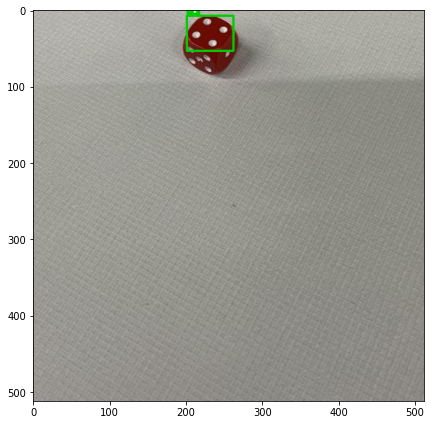

In [24]:
# visualise training time augmentation
idx = 2
train_preview = train_dice_ds[idx]
visualise(train_preview[0], train_preview[1]['boxes'], train_preview[1]['labels'])

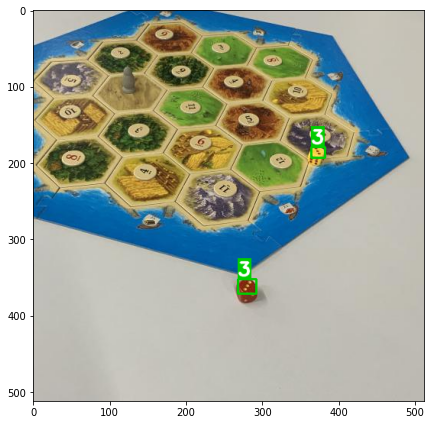

In [25]:
# visualise test time augmentation
idx = 5
val_preview = val_dice_ds[idx]
visualise(val_preview[0], val_preview[1]['boxes'], val_preview[1]['labels'])

## IV. Prepare data for yolov5

In [26]:
# create directories as required by yolo
os.mkdir('data')
os.mkdir('data/images')
os.mkdir('data/images/train')
os.mkdir('data/images/valid')
os.mkdir('data/labels')
os.mkdir('data/labels/train')
os.mkdir('data/labels/valid')

In [27]:
# helper function to split into training and validation sets
def copyfile_train_val(df, origin_dir, destination_dir, val_split=0.2):
  '''Copy files into train and validation directories'''

  for image_id in list(set(df.image_id)):
    image_origin =  origin_dir + '/images/'+image_id+'.jpg'
    label_origin =  origin_dir + '/labels/'+image_id+'.txt'

    #print(os.path.join(origin_dir, 'images/'+image_id+'.jpg'))
    if random.random() > val_split:
      image_desti = os.path.join(destination_dir, 'images/train/'+image_id+'.jpg')
      label_desti = os.path.join(destination_dir, 'labels/train/'+image_id+'.txt')
    else:
      image_desti = os.path.join(destination_dir, 'images/valid/'+image_id+'.jpg')
      label_desti = os.path.join(destination_dir, 'labels/valid/'+image_id+'.txt')

    #print(image_desti)
    #print(label_desti)
    copyfile(image_origin, image_desti)
    copyfile(label_origin, label_desti)

In [28]:
# copy image and label files into respective directories
origin_dir = 'dice_dataset'
destination_dir = 'data'

copyfile_train_val(raw_df, origin_dir, destination_dir, val_split=0.2)

In [29]:
# create data info file for training
new_data_yaml = yaml_file
new_data_yaml['train'] = os.path.join(os.getcwd(), 'data/images/train')
new_data_yaml['val'] = os.path.join(os.getcwd(), 'data/images/valid')
new_data_yaml = '\n'.join([f'{list(new_data_yaml.keys())[i]}: {list(new_data_yaml.values())[i]}' 
                           for i in range(len(new_data_yaml))])
print(new_data_yaml)
with open("new_data.yaml", 'w') as file:
    file.write(str(new_data_yaml))

train: /content/data/images/train
val: /content/data/images/valid
nc: 6
names: ['1', '2', '3', '4', '5', '6']


In [30]:
# create config file for training
with open("/content/yolov5/models/yolov5s.yaml", 'r') as file:
    raw_model = file.read()

modified_model = raw_model.replace("nc: 80", "nc: 6")
print(modified_model)

with open('new_model.yaml', 'w+') as file:
    file.write(modified_model)

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 6  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],

In [31]:
# create hyperparameter config file for training
with open("/content/yolov5/data/hyps/hyp.scratch-high.yaml", 'r') as file:
    old_hyps = file.read()
#print(old_hyps)
new_hyps = """
    # Hyperparameters for pre-training on public dice dataset

    lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
    lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
    momentum: 0.937  # SGD momentum/Adam beta1
    weight_decay: 0.0005  # optimizer weight decay 5e-4
    warmup_epochs: 3.0  # warmup epochs (fractions ok)
    warmup_momentum: 0.8  # warmup initial momentum
    warmup_bias_lr: 0.1  # warmup initial bias lr
    box: 0.05  # box loss gain
    cls: 0.3  # cls loss gain
    cls_pw: 1.0  # cls BCELoss positive_weight
    obj: 0.7  # obj loss gain (scale with pixels)
    obj_pw: 1.0  # obj BCELoss positive_weight
    iou_t: 0.20  # IoU training threshold
    anchor_t: 4.0  # anchor-multiple threshold
    # anchors: 3  # anchors per output layer (0 to ignore)
    fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
    hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
    hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
    hsv_v: 0.4  # image HSV-Value augmentation (fraction)
    degrees: 0.0  # image rotation (+/- deg)
    translate: 0.1  # image translation (+/- fraction)
    scale: 0.9  # image scale (+/- gain)
    shear: 0.0  # image shear (+/- deg)
    perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
    flipud: 0.0  # image flip up-down (probability)
    fliplr: 0.5  # image flip left-right (probability)
    mosaic: 1.0  # image mosaic (probability)
    mixup: 0.1  # image mixup (probability)
    copy_paste: 0.1  # segment copy-paste (probability)
"""

with open("new_hyps.yaml", 'w') as file:
    file.write(new_hyps)

In [57]:
with open("/content/new_data.yaml", 'r') as file:
  print(file.read())

train: /content/data/images/train
val: /content/data/images/valid
nc: 6
names: ['1', '2', '3', '4', '5', '6']


In [54]:
os.getcwd()

'/content'

In [53]:
os.chdir("..")

In [ ]:
# create data info file for training
new_test_data_yaml = yaml_file
new_test_data_yaml['val'] = os.path.join(os.getcwd(), 'data_finetune_small/images/valid')
new_test_data_yaml = '\n'.join([f'{list(new_test_data_yaml.keys())[i]}: {list(new_test_data_yaml.values())[i]}' 
                           for i in range(len(new_test_data_yaml))])
print(new_test_data_yaml)
with open("new_test_data.yaml", 'w') as file:
  file.write(str(new_test_data_yaml))

train: /content/data/images/train
val: /content/data_finetune_small/images/valid
nc: 6
names: ['1', '2', '3', '4', '5', '6']


In [ ]:
os.chdir("dice-detection-for-board-games/data_finetune_small")
os.getcwd()

'/content/dice-detection-for-board-games/data_finetune_small'

In [ ]:
# create data info file for training
finetune_small_data_yaml = yaml_file
finetune_small_data_yaml['train'] = os.path.join(os.getcwd(), 'images/train')
finetune_small_data_yaml['val'] = os.path.join(os.getcwd(), 'images/valid')
finetune_small_data_yaml = '\n'.join([f'{list(finetune_small_data_yaml.keys())[i]}: {list(finetune_small_data_yaml.values())[i]}' 
                           for i in range(len(finetune_small_data_yaml))])
print(finetune_small_data_yaml)
with open("/content/finetune_small_data.yaml", 'w') as file:
  file.write(str(finetune_small_data_yaml))

train: /content/dice-detection-for-board-games/data_finetune_small/images/train
val: /content/dice-detection-for-board-games/data_finetune_small/images/valid
nc: 6
names: ['1', '2', '3', '4', '5', '6']


## V. Pre-train model on public dataset

In [32]:
os.chdir('yolov5')

In [33]:
os.getcwd()

'/content/yolov5'

In [34]:
# train for 500 epochs with learning rate decay
#%%time
start_time = time.time()
!python train.py \
    --hyp '/content/new_hyps.yaml' \
    --optimizer Adam \
    --img-size 512 \
    --batch 8 \
    --epochs 1000 \
    --data '/content/new_data.yaml' \
    --cfg '/content/new_model.yaml' \
    --weights yolov5s.pt
print("--- %s seconds ---" % (time.time() - start_time))

wandb: Currently logged in as: fudw (use `wandb login --relogin` to force relogin)
train: weights=yolov5s.pt, cfg=/content/new_model.yaml, data=/content/new_data.yaml, hyp=/content/new_hyps.yaml, epochs=1000, batch_size=8, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-157-g7043872 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.

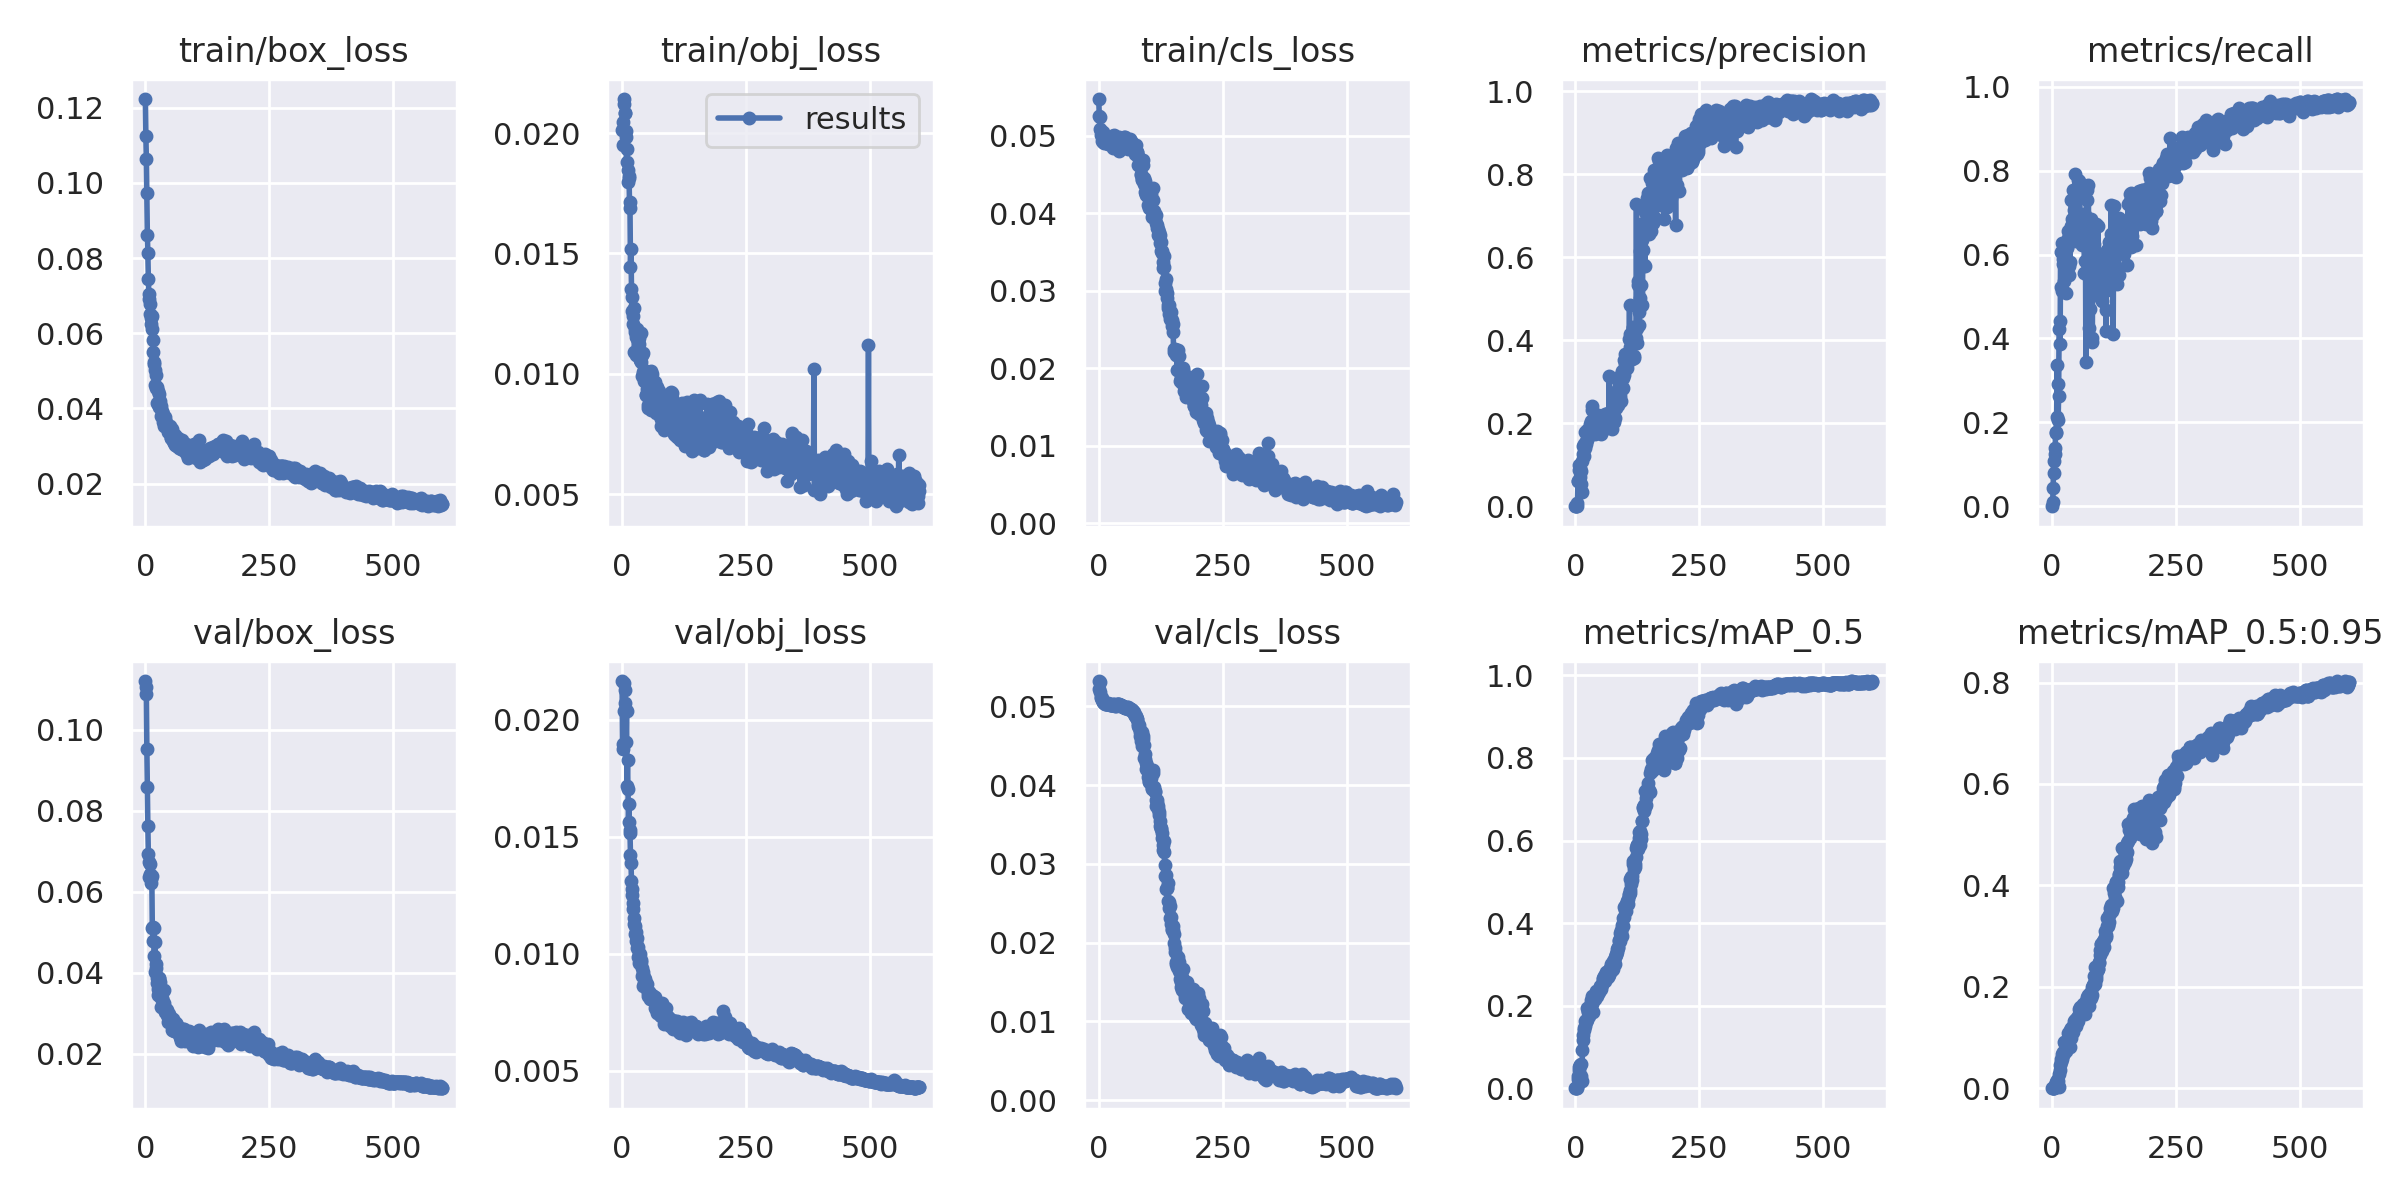

In [ ]:
# check training metrics
Image.open('/home/dawaifu/dice-detection-for-board-games/yolov5/runs/train/exp3/results.png')

In [ ]:
# check training batch augmentations
Image.open('/home/dawaifu/dice-detection-for-board-games/yolov5/runs/train/exp3/train_batch0.jpg')

In [ ]:
# check validation batch labels
Image.open('/home/dawaifu/dice-detection-for-board-games/yolov5/runs/train/exp3/val_batch0_labels.jpg')

In [ ]:
# check validation batch predictions
Image.open('/home/dawaifu/dice-detection-for-board-games/yolov5/runs/train/exp3/val_batch2_pred.jpg')

In [ ]:
# predict on validation data
! python detect.py --source /home/dawaifu/dice-detection-for-board-games/dice_fechner_small/  --weights /home/dawaifu/dice-detection-for-board-games/weights/pretrained-ckpt.pt --conf 0.5

detect: weights=['/home/dawaifu/dice-detection-for-board-games/weights/pretrained-ckpt.pt'], source=/home/dawaifu/dice-detection-for-board-games/dice_fechner_small/, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-380-g11f85e7 torch 1.9.0+cu102 CUDA:0 (Quadro M4000, 8118.5625MB)

Fusing layers... 
Model Summary: 232 layers, 7260003 parameters, 0 gradients, 16.8 GFLOPs
image 1/20 /home/dawaifu/dice-detection-for-board-games/dice_fechner_small/IMG_4540.jpeg: 640x480 1 1, 4 3s, 3 4s, 1 5, Done. (0.032s)
image 2/20 /home/dawaifu/dice-detection-for-board-games/dice_fechner_small/IMG_4541.jpeg: 640x480 2 2s, 4 3s, 5 4s, 6 6s, Done. (0.017s)
image 3/20 /home/dawaifu/dice-detection-for-bo

In [ ]:
os.getcwd()

'/home/dawaifu/dice-detection-for-board-games/data_finetune_small'

In [ ]:
os.chdir('data_finetune_small')

In [ ]:
os.mkdir('labels')

In [ ]:
# check prediction on validation image
pred_dir = '/home/dawaifu/dice-detection-for-board-games/yolov5/runs/detect/exp'
pred_images = os.listdir(pred_dir)
#print(random.choice(pred_images))
Image.open(os.path.join(pred_dir, random.choice(pred_images)))

In [ ]:
os.getcwd()

'/content/dice-detection-for-board-games/data_finetune_small'

In [ ]:
os.chdir('/content/yolov5')

### Fine-tune on small real dataset

In [ ]:
start_time = time.time()
!python train.py \
    --img-size 512 \
    --batch 4 \
    --epochs 1000 \
    --optimizer Adam \
    --data '/content/finetune_small_data.yaml' \
    --cfg '/content/new_train_yaml' \
    --weights '/content/dice-detection-for-board-games/weights/pretrained-ckpt.pt'
#--hyp '/content/dice-detection-for-board-games/yolov5/data/hyps/hyp.finetune.small.yaml' \
print("--- %s seconds ---" % (time.time() - start_time))

wandb: Currently logged in as: fudw (use `wandb login --relogin` to force relogin)
train: weights=/content/dice-detection-for-board-games/weights/pretrained-ckpt.pt, cfg=/content/new_train_yaml, data=/content/finetune_small_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1000, batch_size=4, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-155-g404b4fe torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, war

## VI. Evaluate performance on test set

In [ ]:
! python val.py --data '/home/dawaifu/dice-detection-for-board-games/new_test_data.yaml' --weights /home/dawaifu/dice-detection-for-board-games/weights/pretrained-ckpt.pt --img 2048

val: data=/home/dawaifu/dice-detection-for-board-games/new_test_data.yaml, weights=['/home/dawaifu/dice-detection-for-board-games/weights/pretrained-ckpt.pt'], batch_size=32, imgsz=2048, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False
YOLOv5 🚀 v5.0-380-g11f85e7 torch 1.9.0+cu102 CUDA:0 (Quadro M4000, 8118.5625MB)

Fusing layers... 
Model Summary: 232 layers, 7260003 parameters, 0 gradients, 16.8 GFLOPs
val: Scanning '/home/dawaifu/dice-detection-for-board-games/dice_fechner_small/l
val: Scanning '/home/dawaifu/dice-detection-for-board-games/dice_fechner_small/l
val: Scanning '/home/dawaifu/dice-detection-for-board-games/dice_fechner_small/l
val: Scanning '/home/dawaifu/dice-detection-for-board-games/dice_fechner_small/l
val: Scanning '/home/dawaifu/dice-detection-for-board-games/dice_fechner_small/l
             

In [ ]:
! python detect.py --source '/home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid'  --weights '/home/dawaifu/dice-detection-for-board-games/weights/best.pt' --conf 0.5 --img=756

detect: weights=['/home/dawaifu/dice-detection-for-board-games/weights/best.pt'], source=/home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid, imgsz=[756, 756], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-380-g11f85e7 torch 1.9.0+cu102 CUDA:0 (Quadro M4000, 8118.5625MB)

Fusing layers... 
Model Summary: 232 layers, 7260003 parameters, 0 gradients, 16.8 GFLOPs
image 1/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/0kpaB4UeoohBVODkOmGd.jpg: 768x576 Done. (0.027s)
image 2/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/1XPc36ZuLHMLotkAKZfP.jpg: 768x576 1 1, Done. (0.027s)
image 3/157 /home/dawaifu/dice-detection-for-board-

image 50/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/IMG_0722_jpeg.rf.a528c942de6e76e97423f52d36762836.jpg: 768x576 2 1s, Done. (0.026s)
image 51/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/IMG_0724_jpeg.rf.cf2f1dc7a223309ad26b0826a825e5d4.jpg: 768x576 Done. (0.024s)
image 52/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/IMG_0733_jpeg.rf.2c2fcd6b2c4a3face4cb378930d8397d.jpg: 768x576 2 1s, Done. (0.024s)
image 53/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/IMG_0734_jpeg.rf.0e2d7783aa97bf60bcd1d13c208542c0.jpg: 768x576 3 1s, Done. (0.024s)
image 54/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/IMG_0736_jpeg.rf.6c3029b270923d269890874a3ca7d30b.jpg: 768x576 Done. (0.023s)
image 55/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/IMG_0741_jpeg.rf.a9b2b8b037bea2ba43725a86b4c014aa.jpg: 768x576 1 1, Done. (0.024s)

image 104/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/fKQVA8QBGdTU7rENPa4f.jpg: 768x576 Done. (0.022s)
image 105/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/feIbstuqkhgqrCg1Z7na.jpg: 768x576 Done. (0.023s)
image 106/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/gzbCH4ztcYDb6Gw813gg.jpg: 768x576 2 1s, Done. (0.023s)
image 107/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/hBGHSHoJja4YOPqBN4P1.jpg: 768x576 1 1, Done. (0.023s)
image 108/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/i.rf.1062695df832beeb90b57da808907cc9.jpg: 768x576 1 2, Done. (0.023s)
image 109/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/i.rf.12fb7b1e73f3d9aaca5e44e9bc971e3e.jpg: 768x576 1 4, Done. (0.023s)
image 110/157 /home/dawaifu/dice-detection-for-board-games/data_pretrain/images/valid/i.rf.223581e6909183def1993ffae3d7eb7e.jpg: 768x57